In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from itertools import product
from math import log

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import altair as alt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from arch import arch_model

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose, STL

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max.columns', None)
pd.set_option('display.max.rows', None)

# Завантаження та підготовка даних

In [4]:
df_nflx = pd.read_csv('NFLX.csv')

In [5]:
df_nflx.head()

,Date,Open,High,Low,Close,Volume
0,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300
1,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700
2,2016-02-16,89.000000,90.139999,87.540001,89.050003,16356600
3,2016-02-17,90.129997,94.769997,89.639999,94.760002,18323800
4,2016-02-18,94.800003,94.900002,90.309998,90.489998,17695300


In [6]:
def prepare_dataset(df_nflx):
    df_nflx['Date'] = pd.to_datetime(df_nflx['Date'])
    df_nflx['Date_index'] = pd.DatetimeIndex(df_nflx['Date']) 
    
    data_no_missing = df_nflx.copy(deep=True)

    data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data_no_missing[col] = data_no_missing[col].interpolate()

    data_no_missing = data_no_missing.reset_index(drop=False)

    data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
    data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
    data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
    data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month
    
    return df_nflx, data_no_missing

In [7]:
df_nflx, data_no_missing = prepare_dataset(df_nflx)

In [8]:
df_nflx.head()

,Date,Open,High,Low,Close,Volume,Date_index
0,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300,2016-02-11
1,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700,2016-02-12
2,2016-02-16,89.000000,90.139999,87.540001,89.050003,16356600,2016-02-16
3,2016-02-17,90.129997,94.769997,89.639999,94.760002,18323800,2016-02-17
4,2016-02-18,94.800003,94.900002,90.309998,90.489998,17695300,2016-02-18


In [9]:
data_no_missing.head()

,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,2016-02-11,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300.0,2016,1,2
1,2016-02-12,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700.0,2016,1,2
2,2016-02-13,2016-02-13,87.229999,89.825001,85.830002,87.812502,18389925.0,2016,1,2
3,2016-02-14,2016-02-14,87.819999,89.930000,86.400002,88.225003,17712150.0,2016,1,2
4,2016-02-15,2016-02-15,88.410000,90.034999,86.970001,88.637503,17034375.0,2016,1,2


## Перевірка на стаціонарність

In [10]:
def stationarity_test(ts, stat_test):
    result = stat_test(ts)
    test_name = stat_test.__name__
    
    test_result = {
        test_name + "_statistics": result[0],
        test_name + "_p_value": result[1],
        test_name + "_critical_values": result[4] if test_name == 'adfuller' else result[3] if test_name == 'kpss' else None
    }
    
    return test_result

### Тест Дікі-Фулера

In [11]:
stationarity_test(data_no_missing['Close'], smt.adfuller)

{'adfuller_statistics': -0.1770206363229292,
 'adfuller_p_value': 0.9412058403227873,
 'adfuller_critical_values': {'1%': -3.433976034843506,
  '5%': -2.8631416925158244,
  '10%': -2.5676226884667694}}

### KPSS тест

In [12]:
stationarity_test(data_no_missing['Close'], smt.kpss)

{'kpss_statistics': 6.214577387345509,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

### Можемо зробити висновок, що вихідний часовий ряд не є стаціонарним

In [13]:
data_no_missing.head(1)

,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,2016-02-11,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300.0,2016,1,2


## Основні функції 

In [14]:
def normalize(df, target_column='Close'):
    ts_log = np.log(df[target_column])
    ts_diff = ts_log.diff(periods=1).dropna()
    stationary_ts = ts_diff.diff(periods=1).dropna()
    
    return stationary_ts, ts_diff, ts_log

In [15]:
def pacf_acf(input_ts, lags=12, figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(input_ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(input_ts, lags=lags, ax=ax2)

In [16]:
def plot_real_predict_ts(stationary_ts, fitted_values, figsize=(8, 10)):
    stationary_ts.plot(figsize=figsize, color = 'black', alpha = .6);
    fitted_values.plot(figsize=figsize, color = 'red', alpha = .6);
    plt.legend(['Real time serie', 'Predicted time serie']);
    plt.title('Real and Predicted values for given time series');

In [32]:
def get_predictions(garch_model, test_size):
    preds = pd.Series(garch_model.forecast(horizon=test_size).variance.values[-1], copy=True)
    
    return preds

In [51]:
LIST_METRICS = [lambda real, predictions: np.sqrt(sum((predictions - real) ** 2) / len(real)),
                lambda real, predictions: sum((predictions - real) ** 2), mean_squared_error,
                mean_absolute_error, lambda real, predictions: np.mean(np.abs((real - predictions) / real)),
                r2_score
               ]

TITLE_METRICS = ['RMSE', 'RSS', 'MSE', 'MAE', 'MAPE', 'R2']

In [52]:
QTY_SPLITS = 3

In [53]:
def akaike_criterion(n, mse, num_params):
    return n * log(mse) + 2 * num_params


def bayess_criterion(n, mse, num_params):
    return n * log(mse) + num_params * log(n)

In [54]:
ORDERS_RANGE = range(1, 6)

In [55]:
INDEX = pd.MultiIndex.from_product((ORDERS_RANGE, ORDERS_RANGE, list(range(QTY_SPLITS))))

In [72]:
def calc_metrics(df, predictions, arch, metrics_list=LIST_METRICS,
                 titles_list=TITLE_METRICS
                ):
    
    metrics_df = pd.DataFrame()
    
    for metric, title in zip(metrics_list, titles_list):
        calculated_metric = metric(df, predictions)
        metrics_df.loc[0, title] = calculated_metric
    
    metrics_df['AIC'] = akaike_criterion(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )

    metrics_df['BIC'] = bayess_criterion(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )
    
    return metrics_df

In [81]:
def make_models_range(p, q, vol, df_stationary, df_stationary_test,
                      metrics_list=LIST_METRICS, titles_list=TITLE_METRICS):
    
    try:
        arch = arch_model(np.power(df_stationary, 2), mean='Zero', vol=vol, p=p, q=q)
        arch_fitted = arch.fit()
    
        test_arch_predictions = get_predictions(arch_fitted, df_stationary_test.shape[0])
        test_true = np.array([np.power(df_stationary_test_first, 2).std() ** 2] * df_stationary_test_first.shape[0])

        test_metrics_df_arch = calc_metrics(test_true, test_arch_predictions, arch_fitted)
    
    except ValueError:
        print('P: {}, Q: {}, vol: {}'.format(p, q, vol))
        return pd.DataFrame()
    
    return test_metrics_df_arch

## Розбиття часового ряду на train / validation 

In [82]:
ts = data_no_missing['Close']

folds_indexes = list(TimeSeriesSplit(n_splits=QTY_SPLITS, test_size=200).split(ts))
min_fold_len = min([len(fold[0]) for fold in folds_indexes])

for i in range(len(folds_indexes)):
    folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

### Графік розбиття часового ряду на train/ validation для 1-го фолда 

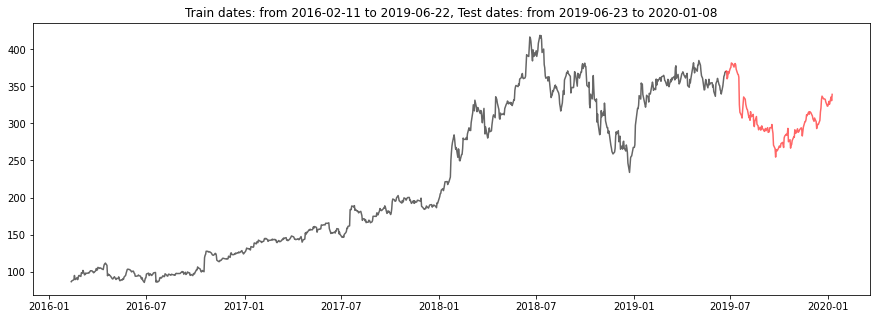

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_first = data_no_missing.loc[folds_indexes[0][0], :]
validate_df_tmp_first = data_no_missing.loc[folds_indexes[0][1], :]

plt.plot(
    train_df_tmp_first['Date'],  train_df_tmp_first['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_first['Date'],  validate_df_tmp_first['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_first.Date.min(), train_df_tmp_first.Date.max(), validate_df_tmp_first.Date.min(), 
    validate_df_tmp_first.Date.max()));

## Побудова першого фолда

In [84]:
train_indexes = folds_indexes[0][0]
test_indexes = folds_indexes[0][1]

train_df_tmp_first = data_no_missing.loc[train_indexes, :]
test_df_tmp_first = data_no_missing.loc[test_indexes, :]

df_stationary_first, data_diffed_first, data_logged_first = normalize(train_df_tmp_first)
df_stationary_test_first, data_diffed_test_first, data_logged_test_first = normalize(test_df_tmp_first)

## Побудова моделей для різних порядків

In [131]:
test_metrics_df_first_fold = pd.DataFrame()

In [132]:
for vol in ['ARCH', 'GARCH', 'EGARCH', 'FIARCH']:
    for p, q in product(ORDERS_RANGE, ORDERS_RANGE):
        test_metrics_df_arch = make_models_range(p, q, vol, df_stationary_first, df_stationary_test_first)
        if not test_metrics_df_arch.empty:
            test_metrics_df_arch.index = pd.Series(str((p, q, vol, 1)))
        
        test_metrics_df_first_fold = pd.concat((test_metrics_df_first_fold, test_metrics_df_arch))

Iteration:      1,   Func. Count:      4,   Neg. LLF: -4839.202948972481
Iteration:      2,   Func. Count:     10,   Neg. LLF: -5991.079274112963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5991.079274428928
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -4839.202948972481
Iteration:      2,   Func. Count:     10,   Neg. LLF: -5991.079274112963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5991.079274428928
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -4839.202948972481
Iteration:      2,   Func. Count:     10,   Neg. LLF: -5991.079274112963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5991.079274428928
            Iterations: 6
           

Iteration:      1,   Func. Count:      6,   Neg. LLF: -5949.933385566467
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5949.933389493952
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -5949.111784981513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5949.1117889432735
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2171062484.5165443
Iteration:      2,   Func. Count:     17,   Neg. LLF: -5968.2066646342755
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5968.206666286456
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -5928.164807384221
Optimizatio

P: 1, Q: 4, vol: EGARCH
Iteration:      1,   Func. Count:      9,   Neg. LLF: 713763152.1943059
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3898.8592623670456
Iteration:      3,   Func. Count:     32,   Neg. LLF: -5993.443112987661
Iteration:      4,   Func. Count:     40,   Neg. LLF: -5992.066641698548
Iteration:      5,   Func. Count:     49,   Neg. LLF: -5998.173589035357
Iteration:      6,   Func. Count:     57,   Neg. LLF: -5998.424076930117
Iteration:      7,   Func. Count:     65,   Neg. LLF: -5998.589795433341
Iteration:      8,   Func. Count:     73,   Neg. LLF: -5998.648315257817
Iteration:      9,   Func. Count:     81,   Neg. LLF: -5998.653836459889
Iteration:     10,   Func. Count:     89,   Neg. LLF: -5998.654140834076
Iteration:     11,   Func. Count:     97,   Neg. LLF: -5998.654146746205
Iteration:     12,   Func. Count:    104,   Neg. LLF: -5998.654146746122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5998.6541

Iteration:      1,   Func. Count:     10,   Neg. LLF: 1715152064.715653
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4820.529431487758
Iteration:      3,   Func. Count:     38,   Neg. LLF: 975.8681228178175
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2171062484.5165443
Iteration:      5,   Func. Count:     62,   Neg. LLF: -5978.130855132225
Iteration:      6,   Func. Count:     71,   Neg. LLF: 69839876.79415046
Iteration:      7,   Func. Count:     81,   Neg. LLF: -6004.663505769193
Iteration:      8,   Func. Count:     90,   Neg. LLF: -6006.050981368469
Iteration:      9,   Func. Count:     99,   Neg. LLF: -5988.210110105176
Iteration:     10,   Func. Count:    109,   Neg. LLF: -6010.33482405086
Iteration:     11,   Func. Count:    119,   Neg. LLF: -6011.507983174017
Iteration:     12,   Func. Count:    128,   Neg. LLF: -6011.52645152412
Iteration:     13,   Func. Count:    137,   Neg. LLF: -6011.532531475808
Iteration:     14,   Func. Count:    146,   Neg. LLF: -60

Iteration:     12,   Func. Count:    158,   Neg. LLF: -6037.171323360557
Iteration:     13,   Func. Count:    169,   Neg. LLF: -6024.563514489805
Iteration:     14,   Func. Count:    181,   Neg. LLF: -6042.045581394358
Iteration:     15,   Func. Count:    192,   Neg. LLF: -6044.757732545522
Iteration:     16,   Func. Count:    203,   Neg. LLF: -6045.037124939683
Iteration:     17,   Func. Count:    214,   Neg. LLF: -6045.268084259078
Iteration:     18,   Func. Count:    225,   Neg. LLF: -6045.502484960061
Iteration:     19,   Func. Count:    236,   Neg. LLF: -6045.811984770875
Iteration:     20,   Func. Count:    247,   Neg. LLF: -6045.876468792996
Iteration:     21,   Func. Count:    258,   Neg. LLF: -6045.905955533301
Iteration:     22,   Func. Count:    269,   Neg. LLF: -6045.912460363522
Iteration:     23,   Func. Count:    280,   Neg. LLF: -6045.914080614201
Iteration:     24,   Func. Count:    291,   Neg. LLF: -6045.914236010198
Iteration:     25,   Func. Count:    302,   Neg. LL

In [133]:
test_metrics_df_first_fold.shape

(50, 8)

In [134]:
test_metrics_df_first_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
"(1, 1, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143
"(1, 2, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143
"(1, 3, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143
"(1, 4, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143
"(1, 5, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143
"(2, 1, 'ARCH', 1)",0.000003,2.232880e-09,1.127717e-11,0.000003,2.044888,-2.514894e+32,-4985.231627,-4975.366826
"(2, 2, 'ARCH', 1)",0.000003,2.232880e-09,1.127717e-11,0.000003,2.044888,-2.514894e+32,-4985.231627,-4975.366826
"(2, 3, 'ARCH', 1)",0.000003,2.232880e-09,1.127717e-11,0.000003,2.044888,-2.514894e+32,-4985.231627,-4975.366826
"(2, 4, 'ARCH', 1)",0.000003,2.232880e-09,1.127717e-11,0.000003,2.044888,-2.514894e+32,-4985.231627,-4975.366826
"(2, 5, 'ARCH', 1)",0.000003,2.232880e-09,1.127717e-11,0.000003,2.044888,-2.514894e+32,-4985.231627,-4975.366826


### Графік розбиття часового ряду на train/ validation для 2-го фолда 

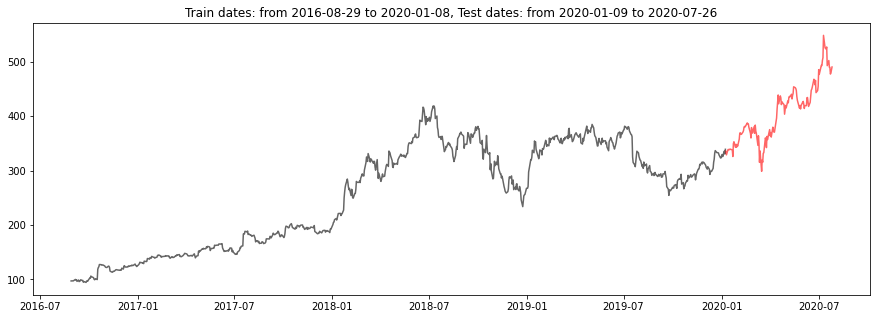

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_second = data_no_missing.loc[folds_indexes[1][0], :]
validate_df_tmp_second = data_no_missing.loc[folds_indexes[1][1], :]

plt.plot(
    train_df_tmp_second['Date'],  train_df_tmp_second['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_second['Date'],  validate_df_tmp_second['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_second.Date.min(), train_df_tmp_second.Date.max(), validate_df_tmp_second.Date.min(),
    validate_df_tmp_second.Date.max()));

## Побудова 2-го фолда

In [136]:
train_indexes = folds_indexes[1][0]
test_indexes = folds_indexes[1][1]

train_df_tmp_second = data_no_missing.loc[train_indexes, :]
test_df_tmp_second = data_no_missing.loc[test_indexes, :]

df_stationary_second, data_diffed_second, data_logged_second = normalize(train_df_tmp_second)
df_stationary_test_second, data_diffed_test_second, data_logged_test_second = normalize(test_df_tmp_second)

## Побудова моделей для різних порядків

In [141]:
test_metrics_df_second_fold = pd.DataFrame()

In [142]:
for vol in ['ARCH', 'GARCH', 'EGARCH', 'FIARCH']:
    for p, q in product(ORDERS_RANGE, ORDERS_RANGE):
        test_metrics_df_arch = make_models_range(p, q, vol, df_stationary_second, df_stationary_test_second)
        if not test_metrics_df_arch.empty:
            test_metrics_df_arch.index = pd.Series(str((p, q, vol, 2)))
        
        test_metrics_df_second_fold = pd.concat((test_metrics_df_second_fold, test_metrics_df_arch))

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2210880104.563504
Iteration:      2,   Func. Count:      9,   Neg. LLF: -5068.735486263603
Iteration:      3,   Func. Count:     15,   Neg. LLF: -6111.426413039808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6111.426413207929
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2210880104.563504
Iteration:      2,   Func. Count:      9,   Neg. LLF: -5068.735486263603
Iteration:      3,   Func. Count:     15,   Neg. LLF: -6111.426413039808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6111.426413207929
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2210880104.563504
Iteration:      2,   Func. Count:      9,   Neg. LLF: -5068.735486263603
Ite

Iteration:      1,   Func. Count:      7,   Neg. LLF: -6053.948402845811
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6053.948404081888
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -6053.948402845811
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6053.948404081888
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -6053.948402845811
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6053.948404081888
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -6053.948402845811
Optimization terminated successfully    (Exit mode 0)
            Current function valu

Iteration:      1,   Func. Count:     13,   Neg. LLF: 1243821502.4283457
Iteration:      2,   Func. Count:     25,   Neg. LLF: -6080.81441269159
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6080.8144129662605
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1229727761.7024841
Iteration:      2,   Func. Count:     13,   Neg. LLF: -3532.442431954128
Iteration:      3,   Func. Count:     20,   Neg. LLF: -6110.846819144164
Iteration:      4,   Func. Count:     24,   Neg. LLF: -6110.891532273308
Iteration:      5,   Func. Count:     28,   Neg. LLF: -6110.908004080914
Iteration:      6,   Func. Count:     32,   Neg. LLF: -6110.908674233458
Iteration:      7,   Func. Count:     36,   Neg. LLF: -6110.909336517565
Iteration:      8,   Func. Count:     40,   Neg. LLF: -6110.909372966051
Iteration:      9,   Func. Count:     44,   Neg. LLF: -6110.90

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1717437104.669706
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4751.785590223082
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2210880104.563504
Iteration:      4,   Func. Count:     42,   Neg. LLF: 366546.25899302994
Iteration:      5,   Func. Count:     52,   Neg. LLF: -5962.91041238859
Iteration:      6,   Func. Count:     60,   Neg. LLF: -6082.569970332372
Iteration:      7,   Func. Count:     68,   Neg. LLF: -5655.394503993781
Iteration:      8,   Func. Count:     76,   Neg. LLF: -6050.673377848791
Iteration:      9,   Func. Count:     84,   Neg. LLF: -6113.197386132874
Iteration:     10,   Func. Count:     92,   Neg. LLF: -6113.086542421635
Iteration:     11,   Func. Count:    100,   Neg. LLF: -6119.791470291345
Iteration:     12,   Func. Count:    107,   Neg. LLF: -6120.0234674954445
Iteration:     13,   Func. Count:    114,   Neg. LLF: -6120.295228272753
Iteration:     14,   Func. Count:    121,   Neg. LLF: 

Iteration:      9,   Func. Count:    113,   Neg. LLF: -6109.754088625374
Iteration:     10,   Func. Count:    124,   Neg. LLF: -6120.848147200644
Iteration:     11,   Func. Count:    134,   Neg. LLF: -6121.513095003449
Iteration:     12,   Func. Count:    144,   Neg. LLF: -6121.8388905296
Iteration:     13,   Func. Count:    154,   Neg. LLF: -6122.073034469417
Iteration:     14,   Func. Count:    164,   Neg. LLF: -6121.6078893002195
Iteration:     15,   Func. Count:    175,   Neg. LLF: -6123.449234443999
Iteration:     16,   Func. Count:    185,   Neg. LLF: -6125.331455064306
Iteration:     17,   Func. Count:    195,   Neg. LLF: -6125.728282842344
Iteration:     18,   Func. Count:    205,   Neg. LLF: -6125.785283373774
Iteration:     19,   Func. Count:    215,   Neg. LLF: -6125.824528889026
Iteration:     20,   Func. Count:    225,   Neg. LLF: -6125.826735813223
Iteration:     21,   Func. Count:    235,   Neg. LLF: -6125.826879217766
Iteration:     22,   Func. Count:    245,   Neg. LLF

Iteration:     16,   Func. Count:    222,   Neg. LLF: -6150.441091883349
Iteration:     17,   Func. Count:    234,   Neg. LLF: -6150.54358231388
Iteration:     18,   Func. Count:    246,   Neg. LLF: -6150.611619912869
Iteration:     19,   Func. Count:    258,   Neg. LLF: -6150.648523105704
Iteration:     20,   Func. Count:    270,   Neg. LLF: -6150.663132216609
Iteration:     21,   Func. Count:    282,   Neg. LLF: -6150.664169486108
Iteration:     22,   Func. Count:    294,   Neg. LLF: -6150.664202610966
Iteration:     23,   Func. Count:    306,   Neg. LLF: -6150.664203958813
Iteration:     24,   Func. Count:    317,   Neg. LLF: -6150.664203960205
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6150.664203958813
            Iterations: 24
            Function evaluations: 317
            Gradient evaluations: 24
P: 5, Q: 5, vol: EGARCH
P: 1, Q: 1, vol: FIARCH
P: 1, Q: 2, vol: FIARCH
P: 1, Q: 3, vol: FIARCH
P: 1, Q: 4, vol: FIARCH
P: 1, Q: 5, v

In [143]:
test_metrics_df_second_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
"(1, 1, 'ARCH', 2)",0.000002,5.478465e-10,2.766901e-12,0.000002,1.014378,-6.170396e+31,-5265.432020,-5258.855486
"(1, 2, 'ARCH', 2)",0.000002,5.478465e-10,2.766901e-12,0.000002,1.014378,-6.170396e+31,-5265.432020,-5258.855486
"(1, 3, 'ARCH', 2)",0.000002,5.478465e-10,2.766901e-12,0.000002,1.014378,-6.170396e+31,-5265.432020,-5258.855486
"(1, 4, 'ARCH', 2)",0.000002,5.478465e-10,2.766901e-12,0.000002,1.014378,-6.170396e+31,-5265.432020,-5258.855486
"(1, 5, 'ARCH', 2)",0.000002,5.478465e-10,2.766901e-12,0.000002,1.014378,-6.170396e+31,-5265.432020,-5258.855486
"(2, 1, 'ARCH', 2)",0.000002,5.654454e-10,2.855785e-12,0.000002,1.030365,-6.368613e+31,-5257.171549,-5247.306747
"(2, 2, 'ARCH', 2)",0.000002,5.654454e-10,2.855785e-12,0.000002,1.030365,-6.368613e+31,-5257.171549,-5247.306747
"(2, 3, 'ARCH', 2)",0.000002,5.654454e-10,2.855785e-12,0.000002,1.030365,-6.368613e+31,-5257.171549,-5247.306747
"(2, 4, 'ARCH', 2)",0.000002,5.654454e-10,2.855785e-12,0.000002,1.030365,-6.368613e+31,-5257.171549,-5247.306747
"(2, 5, 'ARCH', 2)",0.000002,5.654454e-10,2.855785e-12,0.000002,1.030365,-6.368613e+31,-5257.171549,-5247.306747


### Графік розбиття часового ряду на train/ validation для 3-го фолда 

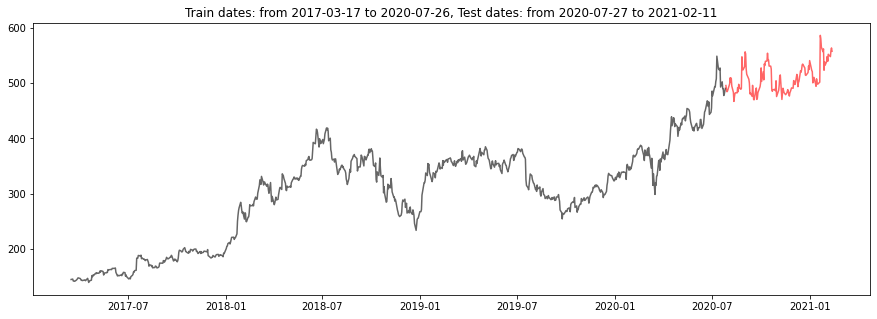

In [144]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_third = data_no_missing.loc[folds_indexes[2][0], :]
validate_df_tmp_third = data_no_missing.loc[folds_indexes[2][1], :]

plt.plot(
    train_df_tmp_third['Date'],  train_df_tmp_third['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_third['Date'],  validate_df_tmp_third['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_third.Date.min(), train_df_tmp_third.Date.max(), validate_df_tmp_third.Date.min(),
    validate_df_tmp_third.Date.max()));

## Побудова 3-го фолда

In [145]:
train_indexes = folds_indexes[2][0]
test_indexes = folds_indexes[2][1]

train_df_tmp_third = data_no_missing.loc[train_indexes, :]
test_df_tmp_third = data_no_missing.loc[test_indexes, :]

df_stationary_third, data_diffed_third, data_logged_third = normalize(train_df_tmp_third)
df_stationary_test_third, data_diffed_test_third, data_logged_test_third = normalize(test_df_tmp_third)

## Побудова моделей для різних порядків

In [146]:
test_metrics_df_third_fold = pd.DataFrame()

In [147]:
for vol in ['ARCH', 'GARCH', 'EGARCH', 'FIARCH']:
    for p, q in product(ORDERS_RANGE, ORDERS_RANGE):
        test_metrics_df_arch = make_models_range(p, q, vol, df_stationary_third, df_stationary_test_third)
        if not test_metrics_df_arch.empty:
            test_metrics_df_arch.index = pd.Series(str((p, q, vol, 3)))
        
        test_metrics_df_third_fold = pd.concat((test_metrics_df_third_fold, test_metrics_df_arch))

Iteration:      1,   Func. Count:      3,   Neg. LLF: -6150.863492528433
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6150.863491449919
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6150.863492528433
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6150.863491449919
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6150.863492528433
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6150.863491449919
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6150.863492528433
Optimization terminated successfully    (Exit mode 0)
            Current function valu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: -6147.967645182081
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6147.967647472487
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -6147.558039398709
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6147.558042685149
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -6122.693790315123
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6122.693787873948
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -6124.284183534767
Inequality constraints incompatible    (Exit mode 4)
            Current function value:

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -6108.4193138142455
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6108.419312534857
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 2010.412326915677
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1967.43371597066
Iteration:      3,   Func. Count:     35,   Neg. LLF: -6111.373584668078
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6111.373588133103
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -6107.546853471351
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6107.546854129021
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -6095.811358432293
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6095.811358699558
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -6093.416819776355
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6093.416820982298
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: 3121293.192685615
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3121291.129385909
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
P: 1, Q: 1, vol: EGARCH
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1712783.295667719
Inequality constraints incompatible    (Exit mode 4)
            Cu

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      9,   Func. Count:     98,   Neg. LLF: -6231.6670614692775
Iteration:     10,   Func. Count:    108,   Neg. LLF: -6239.095928651193
Iteration:     11,   Func. Count:    118,   Neg. LLF: -6240.751300006819
Iteration:     12,   Func. Count:    127,   Neg. LLF: -6243.195413844396
Iteration:     13,   Func. Count:    136,   Neg. LLF: -6241.046029816995
Iteration:     14,   Func. Count:    146,   Neg. LLF: -6243.814717220055
Iteration:     15,   Func. Count:    155,   Neg. LLF: -6243.89250709861
Iteration:     16,   Func. Count:    164,   Neg. LLF: -6243.098830537302
Iteration:     17,   Func. Count:    174,   Neg. LLF: -6243.960288739705
Iteration:     18,   Func. Count:    184,   Neg. LLF: -6244.006756352449
Iteration:     19,   Func. Count:    193,   Neg. LLF: -6244.012546620133
Iteration:     20,   Func. Count:    202,   Neg. LLF: -6244.012606894256
Iteration:     21,   Func. Count:    211,   Neg. LLF: -6244.012615868181
Iteration:     22,   Func. Count:    219,   Neg. LL

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:     79,   Neg. LLF: -6161.951861301701
Iteration:      7,   Func. Count:     90,   Neg. LLF: 161959353.1184155
Iteration:      8,   Func. Count:    101,   Neg. LLF: -6172.8517940914435
Iteration:      9,   Func. Count:    112,   Neg. LLF: -6219.869939989601
Iteration:     10,   Func. Count:    123,   Neg. LLF: -6216.43794109169
Iteration:     11,   Func. Count:    134,   Neg. LLF: -6234.223727782681
Iteration:     12,   Func. Count:    144,   Neg. LLF: -6233.721348500021
Iteration:     13,   Func. Count:    155,   Neg. LLF: -6234.553807674456
Iteration:     14,   Func. Count:    165,   Neg. LLF: -6234.55713007078
Iteration:     15,   Func. Count:    175,   Neg. LLF: -6234.558125225897
Iteration:     16,   Func. Count:    185,   Neg. LLF: -6234.558202062988
Iteration:     17,   Func. Count:    195,   Neg. LLF: -6234.558208438273
Iteration:     18,   Func. Count:    204,   Neg. LLF: -6234.5582084361
Optimization terminated successfully    (Exit mode 0)
 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:     65,   Neg. LLF: 595815711.8403872
Iteration:      6,   Func. Count:     78,   Neg. LLF: 1577016181.8975308
Iteration:      7,   Func. Count:     91,   Neg. LLF: -6192.768087019328
Iteration:      8,   Func. Count:    102,   Neg. LLF: -5587.336646179918
Iteration:      9,   Func. Count:    113,   Neg. LLF: -6227.693006634354
Iteration:     10,   Func. Count:    123,   Neg. LLF: -6232.784778385976
Iteration:     11,   Func. Count:    133,   Neg. LLF: -6232.061245783339
Iteration:     12,   Func. Count:    144,   Neg. LLF: -6238.778901137173
Iteration:     13,   Func. Count:    154,   Neg. LLF: -6241.81070417368
Iteration:     14,   Func. Count:    164,   Neg. LLF: -6238.982776822553
Iteration:     15,   Func. Count:    175,   Neg. LLF: -6243.005066516736
Iteration:     16,   Func. Count:    185,   Neg. LLF: -6243.042368265962
Iteration:     17,   Func. Count:    195,   Neg. LLF: -6243.043447019289
Iteration:     18,   Func. Count:    205,   Neg. LLF:

In [148]:
test_metrics_df_third_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
"(1, 1, 'ARCH', 3)",0.000002,6.676714e-10,3.372078e-12,0.000002,1.117295,-7.519985e+31,-5226.267419,-5219.690885
"(1, 2, 'ARCH', 3)",0.000002,6.676714e-10,3.372078e-12,0.000002,1.117295,-7.519985e+31,-5226.267419,-5219.690885
"(1, 3, 'ARCH', 3)",0.000002,6.676714e-10,3.372078e-12,0.000002,1.117295,-7.519985e+31,-5226.267419,-5219.690885
"(1, 4, 'ARCH', 3)",0.000002,6.676714e-10,3.372078e-12,0.000002,1.117295,-7.519985e+31,-5226.267419,-5219.690885
"(1, 5, 'ARCH', 3)",0.000002,6.676714e-10,3.372078e-12,0.000002,1.117295,-7.519985e+31,-5226.267419,-5219.690885
"(2, 1, 'ARCH', 3)",0.000002,7.859575e-10,3.969482e-12,0.000002,1.211368,-8.852241e+31,-5191.972314,-5182.107513
"(2, 2, 'ARCH', 3)",0.000002,7.859575e-10,3.969482e-12,0.000002,1.211368,-8.852241e+31,-5191.972314,-5182.107513
"(2, 3, 'ARCH', 3)",0.000002,7.859575e-10,3.969482e-12,0.000002,1.211368,-8.852241e+31,-5191.972314,-5182.107513
"(2, 4, 'ARCH', 3)",0.000002,7.859575e-10,3.969482e-12,0.000002,1.211368,-8.852241e+31,-5191.972314,-5182.107513
"(2, 5, 'ARCH', 3)",0.000002,7.859575e-10,3.969482e-12,0.000002,1.211368,-8.852241e+31,-5191.972314,-5182.107513


In [149]:
all_test_metrics = pd.concat((test_metrics_df_first_fold, test_metrics_df_second_fold,
                               test_metrics_df_third_fold)
                             )

In [150]:
all_test_metrics.head(1)

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
"(1, 1, 'ARCH', 1)",0.000003,2.135382e-09,1.078476e-11,0.000003,2.000558,-2.405081e+32,-4996.071677,-4989.495143


In [151]:
all_test_metrics.shape

(150, 8)

In [153]:
idx = all_test_metrics.index.tolist()
idx = [tuple(el.replace('(', '').replace(')', '').split(', ')) for el in idx]
idx = pd.MultiIndex.from_tuples(idx, names=['P', 'Q', 'Vol', 'Fold'])

all_test_metrics.index = idx

In [155]:
all_test_metrics

RMSE           RSS           MSE       MAE      MAPE  \
P Q Vol     Fold                                                             
1 1 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  2 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  3 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  4 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  5 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
2 1 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  2 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  3 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  4 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  5 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
3 1 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  2 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  3 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  4 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  5 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
4 1 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  2 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  3 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  4 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  5 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
5 1 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  2 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  3 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  4 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  5 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
1 1 'GARCH' 1     0.000004  2.734768e-09  1.381196e-11  0.000004  2.265136   
  2 'GARCH' 1     0.000004  2.731529e-09  1.379560e-11  0.000004  2.263724   
  3 'GARCH' 1     0.000004  2.728280e-09  1.377919e-11  0.000004  2.262311   
  4 'GARCH' 1     0.000004  2.725035e-09  1.376280e-11  0.000004  2.260904   
  5 'GARCH' 1     0.000003  1.486289e-09  7.506512e-12  0.000003  1.669887   
2 1 'GARCH' 1     0.000004  2.727874e-09  1.377714e-11  0.000004  2.261833   
  2 'GARCH' 1     0.000004  2.724673e-09  1.376098e-11  0.000004  2.260419   
  3 'GARCH' 1     0.000004  2.711398e-09  1.369393e-11  0.000004  2.253399   
  4 'GARCH' 1     0.000004  2.718226e-09  1.372841e-11  0.000004  2.257601   
  5 'GARCH' 1     0.000004  2.715011e-09  1.371218e-11  0.000004  2.256205   
3 1 'GARCH' 1     0.000004  2.720961e-09  1.374223e-11  0.000004  2.258536   
  2 'GARCH' 1     0.000004  2.717806e-09  1.372629e-11  0.000004  2.257122   
  3 'GARCH' 1     0.000004  2.714616e-09  1.371018e-11  0.000004  2.255712   
  4 'GARCH' 1     0.000004  2.711416e-09  1.369402e-11  0.000004  2.254307   
  5 'GARCH' 1     0.000004  2.708228e-09  1.367792e-11  0.000004  2.252916   
4 1 'GARCH' 1     0.000004  2.706185e-09  1.366760e-11  0.000004  2.250594   
  2 'GARCH' 1     0.000004  2.710908e-09  1.369145e-11  0.000004  2.253822   
  3 'GARCH' 1     0.000004  2.707751e-09  1.367551e-11  0.000004  2.252412   
  4 'GARCH' 1     0.000004  2.704582e-09  1.365950e-11  0.000004  2.251012   
  5 'GARCH' 1     0.000004  2.701420e-09  1.364354e-11  0.000004  2.249626   
5 1 'GARCH' 1     0.000004  2.699298e-09  1.363282e-11  0.000004  2.247291   
  2 'GARCH' 1     0.000004  2.703991e-09  1.365652e-11  0.000004  2.250521   
  3 'GARCH' 1     0.000004  2.700868e-09  1.364075e-11  0.000004  2.249115   
  4 'GARCH' 1     0.000004  2.871596e-09  1.450301e-11  0.000004  2.315430   
  5 'GARCH' 1     0.000004  2.694594e-09  1.

In [156]:
all_test_metrics.to_csv('all_test_metrics_arch.csv', index=True)

### Графічне відображення основних метрик (усереднених по фолдам для кожного з наборів порядків моедлі) для тестової вибірки

#### Тестувальна вибірка

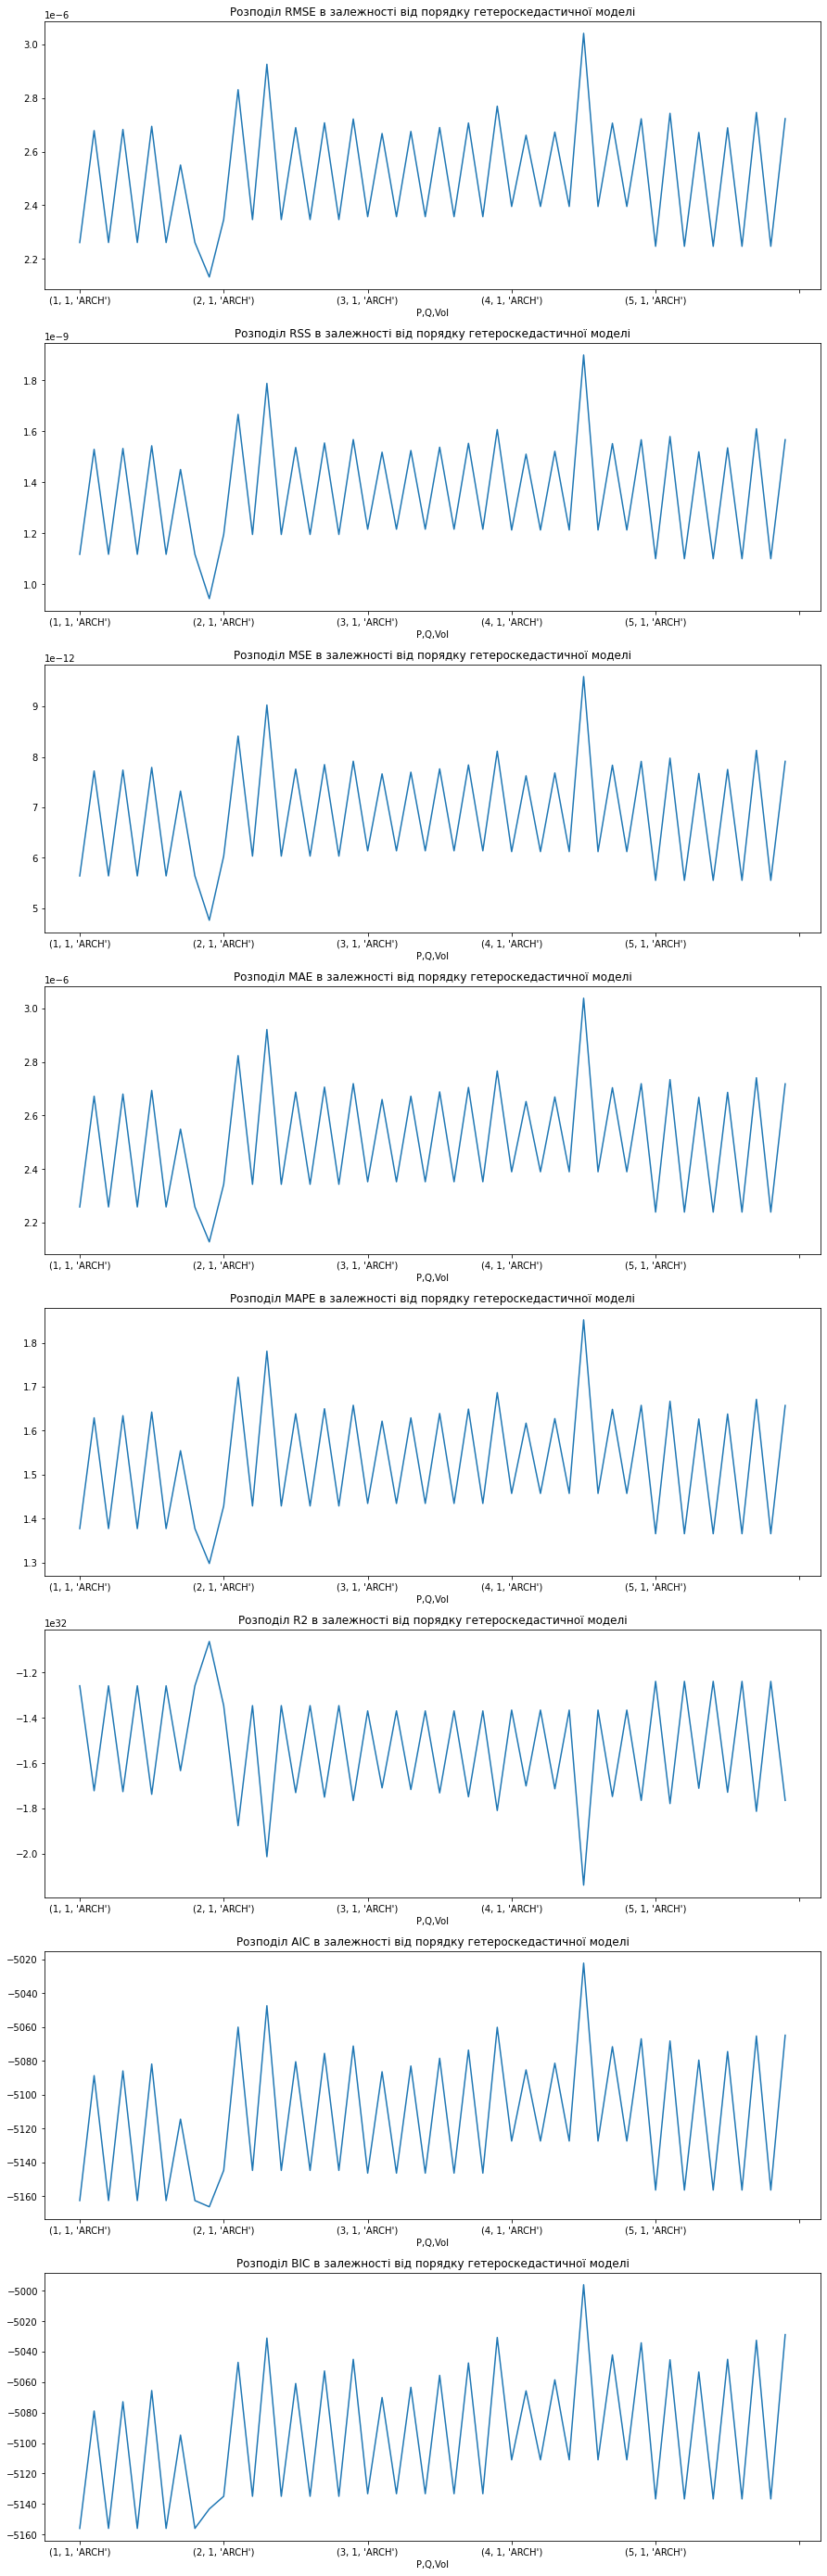

In [157]:
fig, axs = plt.subplots(nrows=all_test_metrics.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_test_metrics.columns):
    all_test_metrics.reset_index().groupby(['P', 'Q', 'Vol'])[metric_title].mean().plot(
        title='Розподіл {} в залежності від порядку гетероскедастичної моделі'.format(metric_title), ax=axs[idx]);

### Побудова ACF та PACF для кожного з фолдів

#### Фолд 1

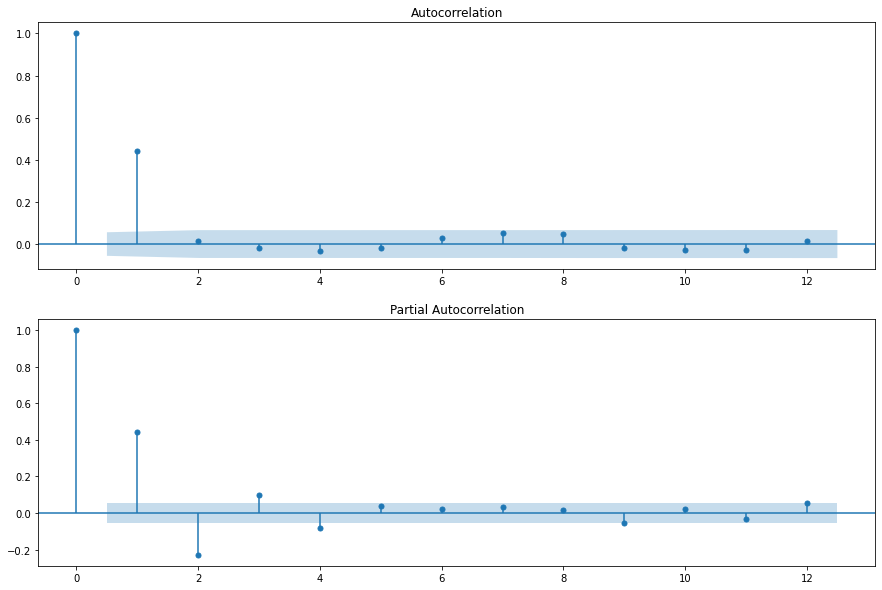

In [158]:
pacf_acf(np.power(df_stationary_first, 2), figsize = (15,10))
plt.show();

#### ARCH(2)

In [160]:
model = arch_model(np.power(df_stationary_first, 2), p=2, q=0, vol='ARCH')
model_fitted = model.fit()

model_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 43402059899894.336
Iteration:      2,   Func. Count:     20,   Neg. LLF: 169790212.36337233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6039.151845318529
            Iterations: 3
            Function evaluations: 29
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6039.15
Distribution:                  Normal   AIC:                          -12070.3
Method:            Maximum Likelihood   BIC:                          -12049.9
                                        No. Observations:                 1226
Date:                Sun, Mar 21 2021   Df Residuals:                     1225
Time:                        20:01:43   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.0659e-04  2.674e-08  2.268e+04      0.000 [6.065e-04,6.066e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.4644e-06  6.066e-12  4.062e+05      0.000 [2.464e-06,2.464e-06]
alpha[1]       0.2500  7.564e-02      3.305  9.499e-04     [  0.102,  0.398]
alpha[2]       0.2500      0.573      0.437      0.662     [ -0.872,  1.372]
============================================================================

Covariance estimator: robust
"""

#### GARCH (2, 2)

In [161]:
model = arch_model(np.power(df_stationary_first, 2), p=2, q=2, vol='GARCH')
model_fitted = model.fit()

model_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 73140426443769.7
Iteration:      2,   Func. Count:     24,   Neg. LLF: 5029870118.914679
Iteration:      3,   Func. Count:     40,   Neg. LLF: 1.4510025598415666e+20
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1.8264725412833555e+24
Iteration:      5,   Func. Count:     73,   Neg. LLF: 91257.47226582438
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 91257.47390318563
            Iterations: 6
            Function evaluations: 73
            Gradient evaluations: 5


/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -91257.5
Distribution:                  Normal   AIC:                           182527.
Method:            Maximum Likelihood   BIC:                           182558.
                                        No. Observations:                 1226
Date:                Sun, Mar 21 2021   Df Residuals:                     1225
Time:                        20:02:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -1.0548  2.211e-06 -4.770e+05      0.000 [ -1.055, -1.055]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.4644e-06  1.471e-11  1.675e+05      0.000 [2.464e-06,2.464e-06]
alpha[1]       0.1000  4.779e-02      2.092  3.640e-02   [6.332e-03,  0.194]
alpha[2]       0.1000      0.112      0.895      0.371     [ -0.119,  0.319]
beta[1]        0.1500      1.610  9.315e-02      0.926     [ -3.006,  3.306]
beta[2]        0.1500      1.162      0.129      0.897     [ -2.128,  2.428]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

#### EGARCH (2, 2)

In [162]:
model = arch_model(np.power(df_stationary_first, 2), p=2, q=2, vol='EGARCH')
model_fitted = model.fit()

model_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.6522856712285623e+23
Iteration:      2,   Func. Count:     24,   Neg. LLF: 197621187638691.94
Iteration:      3,   Func. Count:     36,   Neg. LLF: 3796173044063.84
Iteration:      4,   Func. Count:     46,   Neg. LLF: 28187250806.487114
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1500314846.1316872
Iteration:      6,   Func. Count:     64,   Neg. LLF: 87397261.34197967
Iteration:      7,   Func. Count:     72,   Neg. LLF: -5734.031219389931
Iteration:      8,   Func. Count:     80,   Neg. LLF: -5804.8243032990795
Iteration:      9,   Func. Count:     88,   Neg. LLF: -6025.270967726951
Iteration:     10,   Func. Count:     96,   Neg. LLF: -6005.027371101949
Iteration:     11,   Func. Count:    104,   Neg. LLF: -5957.8557407116405
Iteration:     12,   Func. Count:    112,   Neg. LLF: -6047.561635947366
Iteration:     13,   Func. Count:    120,   Neg. LLF: -6060.97416212213
Iteration:     14,   Func. Count:    128,   Neg. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                6073.04
Distribution:                  Normal   AIC:                          -12134.1
Method:            Maximum Likelihood   BIC:                          -12103.4
                                        No. Observations:                 1226
Date:                Sun, Mar 21 2021   Df Residuals:                     1225
Time:                        20:03:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.8518e-04  6.346e-05      9.221  2.956e-20 [4.608e-04,7.096e-04]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         -3.0101      3.495     -0.861      0.389 [ -9.861,  3.841]
alpha[1]       0.4945  7.515e-02      6.579  4.730e-11 [  0.347,  0.642]
alpha[2]      -0.4124      0.155     -2.652  8.000e-03 [ -0.717, -0.108]
beta[1]        0.7616      0.248      3.072  2.124e-03 [  0.276,  1.247]
beta[2]    3.0677e-10      0.113  2.703e-09      1.000 [ -0.222,  0.222]
========================================================================

Covariance estimator: robust
"""

### Повний вивід метрик

In [166]:
all_test_metrics.shape

(150, 8)

In [168]:
all_test_metrics

RMSE           RSS           MSE       MAE      MAPE  \
P Q Vol     Fold                                                             
1 1 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  2 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  3 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  4 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
  5 'ARCH'  1     0.000003  2.135382e-09  1.078476e-11  0.000003  2.000558   
2 1 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  2 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  3 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  4 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
  5 'ARCH'  1     0.000003  2.232880e-09  1.127717e-11  0.000003  2.044888   
3 1 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  2 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  3 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  4 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
  5 'ARCH'  1     0.000003  2.107026e-09  1.064154e-11  0.000003  1.985519   
4 1 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  2 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  3 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  4 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
  5 'ARCH'  1     0.000003  2.098156e-09  1.059675e-11  0.000003  1.980469   
5 1 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  2 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  3 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  4 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
  5 'ARCH'  1     0.000003  2.089291e-09  1.055198e-11  0.000003  1.975417   
1 1 'GARCH' 1     0.000004  2.734768e-09  1.381196e-11  0.000004  2.265136   
  2 'GARCH' 1     0.000004  2.731529e-09  1.379560e-11  0.000004  2.263724   
  3 'GARCH' 1     0.000004  2.728280e-09  1.377919e-11  0.000004  2.262311   
  4 'GARCH' 1     0.000004  2.725035e-09  1.376280e-11  0.000004  2.260904   
  5 'GARCH' 1     0.000003  1.486289e-09  7.506512e-12  0.000003  1.669887   
2 1 'GARCH' 1     0.000004  2.727874e-09  1.377714e-11  0.000004  2.261833   
  2 'GARCH' 1     0.000004  2.724673e-09  1.376098e-11  0.000004  2.260419   
  3 'GARCH' 1     0.000004  2.711398e-09  1.369393e-11  0.000004  2.253399   
  4 'GARCH' 1     0.000004  2.718226e-09  1.372841e-11  0.000004  2.257601   
  5 'GARCH' 1     0.000004  2.715011e-09  1.371218e-11  0.000004  2.256205   
3 1 'GARCH' 1     0.000004  2.720961e-09  1.374223e-11  0.000004  2.258536   
  2 'GARCH' 1     0.000004  2.717806e-09  1.372629e-11  0.000004  2.257122   
  3 'GARCH' 1     0.000004  2.714616e-09  1.371018e-11  0.000004  2.255712   
  4 'GARCH' 1     0.000004  2.711416e-09  1.369402e-11  0.000004  2.254307   
  5 'GARCH' 1     0.000004  2.708228e-09  1.367792e-11  0.000004  2.252916   
4 1 'GARCH' 1     0.000004  2.706185e-09  1.366760e-11  0.000004  2.250594   
  2 'GARCH' 1     0.000004  2.710908e-09  1.369145e-11  0.000004  2.253822   
  3 'GARCH' 1     0.000004  2.707751e-09  1.367551e-11  0.000004  2.252412   
  4 'GARCH' 1     0.000004  2.704582e-09  1.365950e-11  0.000004  2.251012   
  5 'GARCH' 1     0.000004  2.701420e-09  1.364354e-11  0.000004  2.249626   
5 1 'GARCH' 1     0.000004  2.699298e-09  1.363282e-11  0.000004  2.247291   
  2 'GARCH' 1     0.000004  2.703991e-09  1.365652e-11  0.000004  2.250521   
  3 'GARCH' 1     0.000004  2.700868e-09  1.364075e-11  0.000004  2.249115   
  4 'GARCH' 1     0.000004  2.871596e-09  1.450301e-11  0.000004  2.315430   
  5 'GARCH' 1     0.000004  2.694594e-09  1.